In [1]:
import sys
sys.path.append("..")
from galpy.potential import MiyamotoNagaiPotential, NFWPotential, HernquistPotential
from galpy.actionAngle import estimateDeltaStaeckel, actionAngleStaeckel
from galpy.actionAngle import UnboundError

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
from auriga_functions import *

import numpy as np
from scipy import stats
from IPython.display import Image, display

import corner

import datetime
import random

import copy

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Circle
from matplotlib import animation
from matplotlib.colors import LogNorm
from matplotlib import rcParams

import datetime
%matplotlib inline
rcParams['font.size'] = 16
rcParams['lines.linewidth'] = 1.5
rcParams['axes.linewidth'] = 1.5
rcParams['ytick.major.width'] = 1.5
rcParams['xtick.major.width'] = 1.5
rcParams['image.cmap'] = 'magma'
rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.dpi'] = 300
rcParams['savefig.format'] = 'png'
cmap = copy.copy(plt.cm.get_cmap(rcParams['image.cmap']))
cmap.set_bad((0,0,0))
%config InlineBackend.figure_format = 'retina'



from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Simulation relevant stuff
machine = 'mac'
#machine = 'magny'
machine = 'virgo'

if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
    filedir = "/home/extmilan/masterthesis/files/"
    plotdir = "/home/extmilan/masterthesis/plots/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
    filedir = "/Users/smilanov/Documents/masterthesis/auriga_files/files/"
    plotdir = "/Users/smilanov/Documents/masterthesis/auriga_files/plots/"
elif machine == 'virgo': 
    basedir = "/virgo/simulations/Auriga/level4_MHD/"
    filedir = "/u/milas/masterthesis/masterproject/files/"
    plotdir = "/u/milas/masterthesis/masterproject/plots/"
    
    
#file = filedir + 'potential_params_10000_with_initeqbestfit.txt'

#dopotfit = True
    
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
level = 4

for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"

    for snapnr in range(127,128,1):
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
        

level   : 4
halo    : 24
snapnr  : 127
basedir : /virgo/simulations/Auriga/level4_MHD/
halodir : /virgo/simulations/Auriga/level4_MHD/halo_24/
snappath: /virgo/simulations/Auriga/level4_MHD/halo_24/output/

Found 1783163 stars.
Rotated pos.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [3]:
"""
Snapshot =  127
v0_tot_kms at R0_kpc = 8.02852213383 : 220.724646624
Stellar Disk - a_MND_kpc = 2.96507719743 b_MND_kpc = 1.63627757204 v0_MND_kms = 105.005287928
Stellar Spheroid - a_HB_kp c= 1.71545528287 v0_HB_kms = 111.241910552
DM Halo - a_NFWH_kpc = 26.0152749345 v0_NFWH_kms = 159.117869741
"""
# load all potential parameters
R0_kpc_all, v0_kms_all, a_MND_kpc_all, b_MND_kpc_all, a_NFWH_kpc_all, a_HB_kpc_all, v0_MND_kms_all, v0_NFWH_kms_all, v0_HB_kms_all = np.loadtxt(filedir + 'potential/fitted_potential_params_dec18.txt')

n_MND_all  = v0_MND_kms_all**2  / v0_kms_all**2
n_NFWH_all = v0_NFWH_kms_all**2 / v0_kms_all**2
n_HB_all   = v0_HB_kms_all**2   / v0_kms_all**2

# snap 127:
R0_kpc, v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc = R0_kpc_all[-1], v0_kms_all[-1], a_MND_kpc_all[-1], b_MND_kpc_all[-1], a_NFWH_kpc_all[-1], a_HB_kpc_all[-1]
n_MND, n_NFWH, n_HB = n_MND_all[-1], n_NFWH_all[-1], n_HB_all[-1]

#_____function that sets-up galpy potential_____
def setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB, _REFR0_kpc):
    
    #test input:
    if (a_MND_kpc <= 0.) or (b_MND_kpc <= 0.) or (a_NFWH_kpc <= 0.) or (a_HB_kpc <= 0.) \
       or (n_MND <= 0.) or (n_NFWH <= 0.) or (n_HB <= 0.) or (n_MND >= 1.) or (n_NFWH >= 1.) or (n_HB >= 1.):
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The input parameters for the scaling profiles do not correspond to a physical potential.')
    if np.fabs(n_MND + n_NFWH + n_HB - 1.) > 2e-2:
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The sum of the normalization does not add up to 1.')
        
    #trafo to galpy units:
    a_MND  = a_MND_kpc  / _REFR0_kpc
    b_MND  = b_MND_kpc  / _REFR0_kpc
    a_NFWH = a_NFWH_kpc / _REFR0_kpc
    a_HB   = a_HB_kpc   / _REFR0_kpc
    
    #setup potential:
    disk = MiyamotoNagaiPotential(
                a = a_MND,
                b = b_MND,
                normalize = n_MND)
    halo = NFWPotential(
                a = a_NFWH,
                normalize = n_NFWH)
    bulge = HernquistPotential(
                a = a_HB,
                normalize = n_HB) 
     
    return [disk,halo,bulge]


#for a in range(50):
    

In [43]:
# prepare stuff for progenitors
# load GC IDs & create their mask
colors = ['black', 'black', 'xkcd:hot pink', 'xkcd:indigo blue', 'xkcd:saffron']
for prognr in [2]: #2, 3, 4
    IDs = np.loadtxt(filedir + 'auriga/surviving_GC_wodisk_IDs_prog{}.txt'.format(prognr))
    progcolor = colors[prognr]

    gcmask = np.isin(s.id, IDs)


In [44]:
### for "true" a_NFWH
# set up galpy potential with values of potential fitting (either smoothed or not, depends on commenting out or not)
pot_galpy = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB, R0_kpc)

# this would mean that there are no merged GCs
if np.sum(gcmask) == 0:
    print("skipped this step")
    #continue

# get position and velocities of all selected GCs & convert to galpy units
(R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, gcmask)
# convert physical to galpy units by dividing by REF vals (get velocities from best fit parameters)
R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc / R0_kpc, vR_kms / v0_kms, vphi_kms / v0_kms, z_kpc / R0_kpc, vz_kms / v0_kms

# estimate Delta of the Staeckel potential
delta = 0.45
delta = estimateDeltaStaeckel(pot_galpy, R_galpy, z_galpy)
# CHECK HOW BIG INFLUENCE OF DELTA IS


# set up the actionAngleStaeckel object
aAS = actionAngleStaeckel(
        pot   = pot_galpy,  # potential
        delta = delta,      # focal length of confocal coordinate system
        c     = True        # use C code (for speed)
        )


jR_galpy, lz_galpy, jz_galpy, r_kpc = np.zeros(len(IDs)), np.zeros(len(IDs)), np.zeros(len(IDs)), np.zeros(len(IDs))
savedIDs = np.zeros(len(IDs))
IDs_notworking = []
for test_i, item in enumerate(IDs):
    if (test_i % 1000) == 0:
        print(datetime.datetime.now().time())
        print(test_i)
    try: 
        jR_galpy[test_i], lz_galpy[test_i], jz_galpy[test_i] = aAS(R_galpy[test_i], vR_galpy[test_i], vT_galpy[test_i], z_galpy[test_i], vz_galpy[test_i])
        r_kpc[test_i] = np.sqrt(R_kpc[test_i]**2 + z_kpc[test_i]**2)
        savedIDs[test_i] = item
    except(ValueError, UnboundError):
        IDs_notworking.append(item)
        continue
print('numbers of GCs wo actions:', len(IDs_notworking))
jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * R0_kpc * v0_kms, lz_galpy * R0_kpc * v0_kms, jz_galpy * R0_kpc * v0_kms

# just pick result values of particles of which I actually could calculate actions
survivor_id_mask = np.isin(IDs, savedIDs)
jR_kpckms, lz_kpckms, jz_kpckms = jR_kpckms[survivor_id_mask], lz_kpckms[survivor_id_mask], jz_kpckms[survivor_id_mask]
r_kpc = r_kpc[survivor_id_mask]
survivor_IDs = IDs[survivor_id_mask]
init_jR_kpckms = jR_kpckms
init_jz_kpckms = jz_kpckms

13:47:35.250632
0
numbers of GCs wo actions: 0


In [45]:
init_mean_jR_kpckms = np.mean(jR_kpckms)
init_std_jR_kpckms  = np.std(jR_kpckms)
init_skew_jR_kpckms = stats.skew(jR_kpckms)
init_mean_jz_kpckms = np.mean(jz_kpckms)
init_std_jz_kpckms  = np.std(jz_kpckms)
init_skew_jz_kpckms = stats.skew(jz_kpckms)
init_cov_jR_jz = np.cov(jR_kpckms, jz_kpckms)
init_mean_lz_kpckms = np.mean(lz_kpckms)


In [46]:
### for "false" a_NFWH
#N = 50

from matplotlib.patches import Ellipse



a_NFWH_arr = np.arange(5,46,1)
mean_jR_kpckms = []
std_jR_kpckms  = []
skew_jR_kpckms = []
mean_jz_kpckms = []
std_jz_kpckms  = []
skew_jz_kpckms = []
covs_jR_jz = []
for var_a_NFW_kpc in a_NFWH_arr:
    print("a_NFW = {}".format(var_a_NFW_kpc))
    # set up galpy potential with values of potential fitting (either smoothed or not, depends on commenting out or not)
    try:
        pot_galpy = setup_galpy_potential(a_MND_kpc, b_MND_kpc, var_a_NFW_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB, R0_kpc)
    except:
        mean_jR_kpckms.append(-99.)
        std_jR_kpckms.append(-99.)
        mean_lz_kpckms.append(-99.)
        std_lz_kpckms.append(-99.)
        mean_jz_kpckms.append(-99.)
        std_jz_kpckms.append(-99.)
        print('For a_NFW = {:d} [kpc], no potential can be set up.'.format(var_a_NFW_kpc) )
        continue


    # get position and velocities of all selected GCs & convert to galpy units
    (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, gcmask)
    # convert physical to galpy units by dividing by REF vals (get velocities from best fit parameters)
    R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc / R0_kpc, vR_kms / v0_kms, vphi_kms / v0_kms, z_kpc / R0_kpc, vz_kms / v0_kms

    # estimate Delta of the Staeckel potential
    delta = 0.45
    delta = estimateDeltaStaeckel(pot_galpy, R_galpy, z_galpy)
    # CHECK HOW BIG INFLUENCE OF DELTA IS


    # set up the actionAngleStaeckel object
    aAS = actionAngleStaeckel(
            pot   = pot_galpy,  # potential
            delta = delta,      # focal length of confocal coordinate system
            c     = True        # use C code (for speed)
            )

    num_GCs = len(R_kpc)
    jR_galpy, lz_galpy, jz_galpy, r_kpc = np.zeros(num_GCs), np.zeros(num_GCs), np.zeros(num_GCs), np.zeros(num_GCs)
    savedIDs = np.zeros(num_GCs)
    IDs_notworking = []


    for test_i, item in enumerate(IDs):
        '''        
        if (test_i % 1000) == 0:
            print(datetime.datetime.now().time())
            print(test_i)
        '''
        try: 
            jR_galpy[test_i], lz_galpy[test_i], jz_galpy[test_i] = aAS(R_galpy[test_i], vR_galpy[test_i], vT_galpy[test_i], z_galpy[test_i], vz_galpy[test_i])
            r_kpc[test_i] = np.sqrt(R_kpc[test_i]**2 + z_kpc[test_i]**2)
            savedIDs[test_i] = item
        except(ValueError, UnboundError):
            IDs_notworking.append(item)
            continue
    print('numbers of GCs wo actions:', len(IDs_notworking))
    jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * R0_kpc * v0_kms, lz_galpy * R0_kpc * v0_kms, jz_galpy * R0_kpc * v0_kms

    # just pick result values of particles of which I actually could calculate actions
    survivor_id_mask = np.isin(IDs, savedIDs)
    jR_kpckms, lz_kpckms, jz_kpckms = jR_kpckms[survivor_id_mask], lz_kpckms[survivor_id_mask], jz_kpckms[survivor_id_mask]
    r_kpc = r_kpc[survivor_id_mask]
    survivor_IDs = IDs[survivor_id_mask]

    mean_jR_kpckms.append(np.mean(jR_kpckms))
    std_jR_kpckms.append(np.std(jR_kpckms))
    skew_jR_kpckms.append(stats.skew(jR_kpckms))
    mean_jz_kpckms.append(np.mean(jz_kpckms))
    std_jz_kpckms.append(np.std(jz_kpckms))
    skew_jz_kpckms.append(stats.skew(jz_kpckms))
    cov_jR_jz = np.cov(jR_kpckms, jz_kpckms)
    covs_jR_jz.append(cov_jR_jz)
    
    nstd = 2


a_NFW = 5
numbers of GCs wo actions: 0
a_NFW = 6
numbers of GCs wo actions: 0
a_NFW = 7
numbers of GCs wo actions: 0
a_NFW = 8
numbers of GCs wo actions: 0
a_NFW = 9
numbers of GCs wo actions: 0
a_NFW = 10
numbers of GCs wo actions: 0
a_NFW = 11
numbers of GCs wo actions: 0
a_NFW = 12
numbers of GCs wo actions: 0
a_NFW = 13
numbers of GCs wo actions: 0
a_NFW = 14
numbers of GCs wo actions: 0
a_NFW = 15
numbers of GCs wo actions: 0
a_NFW = 16
numbers of GCs wo actions: 0
a_NFW = 17
numbers of GCs wo actions: 0
a_NFW = 18
numbers of GCs wo actions: 0
a_NFW = 19
numbers of GCs wo actions: 0
a_NFW = 20
numbers of GCs wo actions: 0
a_NFW = 21
numbers of GCs wo actions: 0
a_NFW = 22
numbers of GCs wo actions: 0
a_NFW = 23
numbers of GCs wo actions: 0
a_NFW = 24
numbers of GCs wo actions: 0
a_NFW = 25
numbers of GCs wo actions: 0
a_NFW = 26
numbers of GCs wo actions: 0
a_NFW = 27
numbers of GCs wo actions: 0
a_NFW = 28
numbers of GCs wo actions: 0
a_NFW = 29
numbers of GCs wo actions: 0
a_NFW

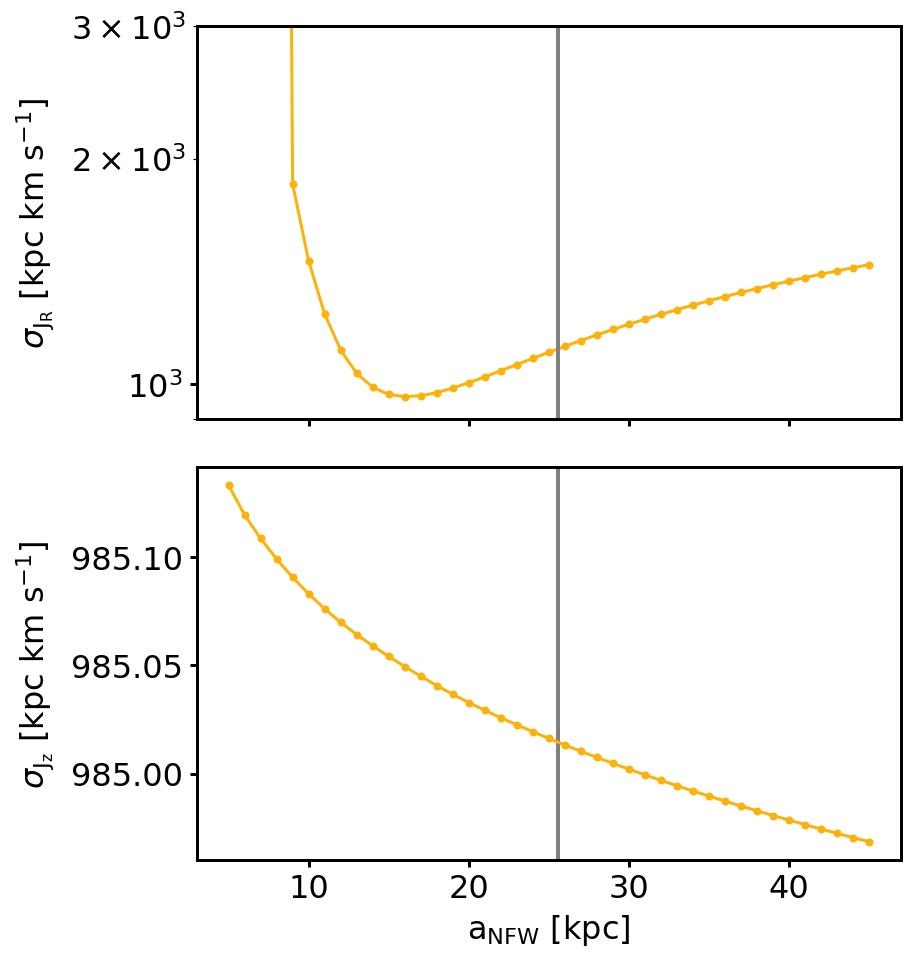

In [52]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (6.8, 7), sharex=True)#, figsize = (15,10))

ax1.semilogy(a_NFWH_arr, std_jR_kpckms, marker = '.', color = progcolor, linestyle = None)
#ax1.plot(init_a_NFWH_kpc, init_std_jR_kpckms, marker = '+', color = 'red')
#ax1.xlabel('a$_{NFW}$')
#ax1.set_yscale("log", nonposy='clip')
#ax1.hlines(init_mean_jR_kpckms, 0, np.max(a_NFWH_arr)+1, color = 'red', alpha = 0.5)
ax1.set_ylim(9e2, 3e3)

ax1.set_ylabel('$\sigma_{\mathrm{J}_\mathrm{R}}$ [kpc km s$^{-1}$]')
#plt.show()

ax1.get_yaxis().set_label_coords(-0.2,0.5)
ax1.axvline(a_NFWH_kpc, color = 'grey', linewidth = 2)
ax2.axvline(a_NFWH_kpc, color = 'grey', linewidth = 2)

ax2.plot(a_NFWH_arr,std_jz_kpckms, marker = '.', color = progcolor)
#ax2.plot(init_a_NFWH_kpc, init_std_jz_kpckms, marker = '+', color = 'red')
#ax2.hlines(init_mean_jz_kpckms, 0, np.max(a_NFWH_arr)+1, color = 'red', alpha = 0.5)

ax2.set_xlabel('a$_\mathrm{NFW}$ [kpc]')
#ax2.set_yscale("log", nonposy='clip')
#ax2.set_ylim(0, None)
ax2.set_ylabel('$\sigma_{\mathrm{J}_\mathrm{z}}$ [kpc km s$^{-1}$]')
#plt.show()
ax2.get_yaxis().set_label_coords(-0.2,0.5)

fig.tight_layout()


fig.savefig(plotdir + 'actions/diagnostic/a_NFW_diagnostic_plot_std_wodiskchange_prog{}_all.png'.format(prognr), dpi = 300, format = 'png')

In [21]:
skew_jz_kpckms

[-0.06452047030675757,
 -0.0650752287392059,
 -0.06559507661611848,
 -0.06608474053189549,
 -0.06654804206947282,
 -0.06698811164144079,
 -0.06740754297050217,
 -0.06780850704251516,
 -0.0681928376725796,
 -0.06856209675307529,
 -0.06891762468507771,
 -0.06926057982810815,
 -0.06959196969438018,
 -0.06991267585348235,
 -0.07022347399594493,
 -0.07052505022474102,
 -0.07081801438659939,
 -0.07110291105186728,
 -0.0713802286235217,
 -0.07165040693023263,
 -0.07191384359940006,
 -0.07217089943073994,
 -0.07242190294862028,
 -0.07266715428244849,
 -0.07290692848058561,
 -0.07314147835992332,
 -0.07337103696285407,
 -0.073595819683843,
 -0.07381602611635507,
 -0.07403184166462976,
 -0.07424343895328114]

In [ ]:
# goal plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)#, figsize = (15,10))

ax1.plot(a_NFWH_arr, np.array(skew_jR_kpckms), 'k.')
ax1.plot(init_a_NFWH_kpc, init_skew_jR_kpckms, marker = '+', color = 'red')
#ax1.xlabel('a$_{NFW}$')
#ax1.set_yscale("log", nonposy='clip')
#ax1.hlines(init_mean_jR_kpckms, 0, np.max(a_NFWH_arr)+1, color = 'red', alpha = 0.5)
#ax1.set_ylim(1, 10)

ax1.set_ylabel('skewness of J$_\mathrm{R}$')
#plt.show()


ax2.plot(a_NFWH_arr, skew_jz_kpckms, 'k.')
#ax2.plot(init_a_NFWH_kpc, init_skew_jz_kpckms, marker = '+', color = 'red')
#ax2.hlines(init_mean_jz_kpckms, 0, np.max(a_NFWH_arr)+1, color = 'red', alpha = 0.5)

ax2.set_xlabel('a$_\mathrm{NFW}$ [kpc]')
#ax2.set_yscale("log", nonposy='clip')
#ax2.set_ylim(1.615, 1.625)
ax2.set_ylabel('skewness of J$_\mathrm{z}$')
#ax2.set_yscale("log")#, nonposy='clip')

#plt.show()

fig.tight_layout()

fig.savefig(plotdir + 'a_NFW_diagnostic_plot_skewness_all.png', dpi = 300, format = 'png')

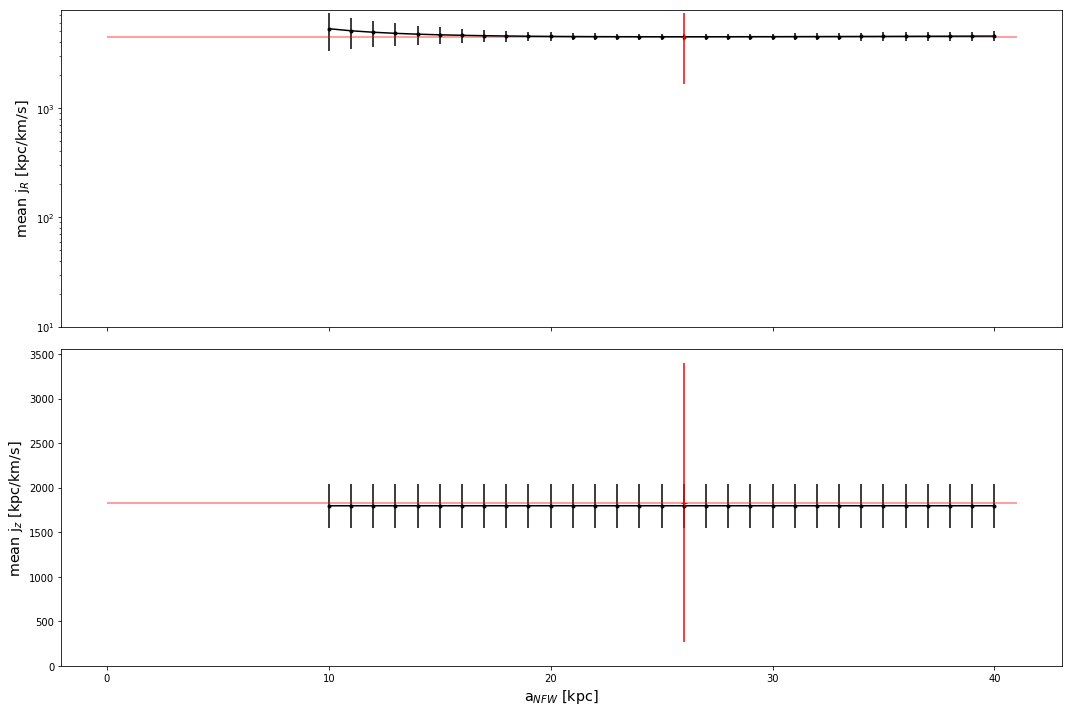

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (15,10))

ax1.errorbar(a_NFWH_arr, np.array(mean_jR_kpckms), yerr = np.array(std_jR_kpckms), marker = '.', color = 'black', linestyle = None)
ax1.errorbar(init_a_NFWH_kpc, init_mean_jR_kpckms, init_std_jR_kpckms, marker = '+', color = 'red')
#ax1.xlabel('a$_{NFW}$')
ax1.set_yscale("log", nonposy='clip')
ax1.hlines(init_mean_jR_kpckms, 0, np.max(a_NFWH_arr)+1, color = 'red', alpha = 0.5)
ax1.set_ylim(10, None)

ax1.set_ylabel('mean j$_R$ [kpc/km/s]', size = 'x-large')
#plt.show()


ax2.errorbar(a_NFWH_arr, mean_jz_kpckms, yerr = std_jz_kpckms, marker = '.', color = 'black')
ax2.errorbar(init_a_NFWH_kpc, init_mean_jz_kpckms, init_std_jz_kpckms, marker = '+', color = 'red')
ax2.hlines(init_mean_jz_kpckms, 0, np.max(a_NFWH_arr)+1, color = 'red', alpha = 0.5)

ax2.set_xlabel('a$_{NFW}$ [kpc]', size = 'x-large')
#ax2.set_yscale("log", nonposy='clip')
ax2.set_ylim(0, None)
ax2.set_ylabel('mean j$_z$ [kpc/km/s]', size = 'x-large')
#plt.show()

fig.tight_layout()

fig.savefig(plotdir + 'a_NFW_diagnostic_plot_mean_std_small_box.png', dpi = 300, format = 'png')

In [13]:
covs_jR_jz

[array([[ 4440169.67380803,  -163450.65251199],
        [ -163450.65251199,    65775.31217777]]),
 array([[ 2842333.41981232,  -129831.36702994],
        [ -129831.36702994,    65769.86129091]]),
 array([[ 1927600.41879206,  -104705.83867015],
        [ -104705.83867015,    65765.35316662]]),
 array([[ 1355669.73985903,   -84976.46691253],
        [  -84976.46691253,    65761.62901752]]),
 array([[ 976450.07344001,  -68922.6056206 ],
        [ -68922.6056206 ,   65758.56252661]]),
 array([[ 714622.09340006,  -55501.97076242],
        [ -55501.97076242,   65756.05191354]]),
 array([[ 528707.81313502,  -44042.31939695],
        [ -44042.31939695,   65754.01425025]]),
 array([[ 394202.66064808,  -34088.75988696],
        [ -34088.75988696,   65752.38130346]]),
 array([[ 295809.97646067,  -25321.50047589],
        [ -25321.50047589,   65751.09643981]]),
 array([[ 223547.7778403 ,  -17508.58793801],
        [ -17508.58793801,   65750.11228594]]),
 array([[ 170659.87457926,  -10477.32001285]

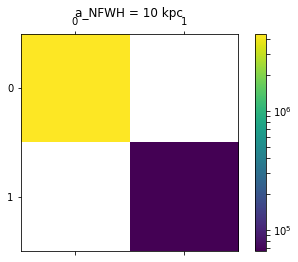

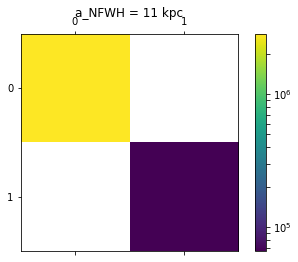

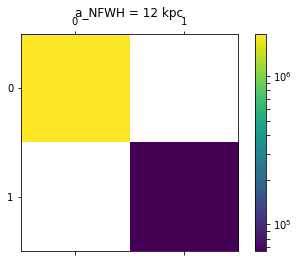

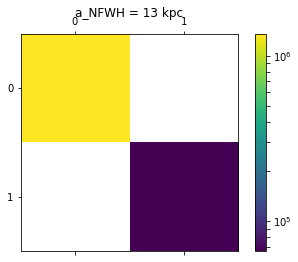

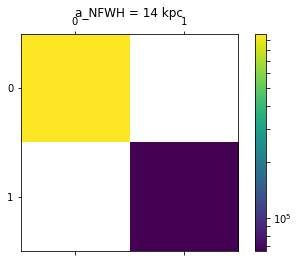

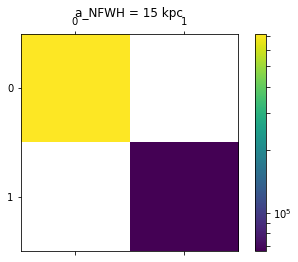

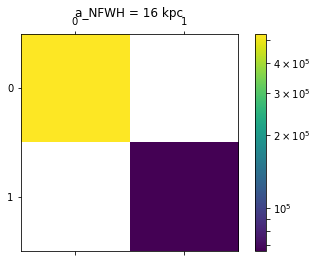

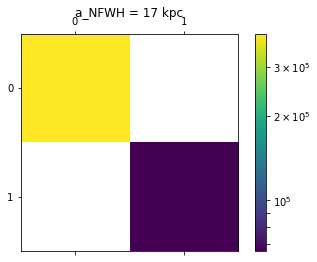

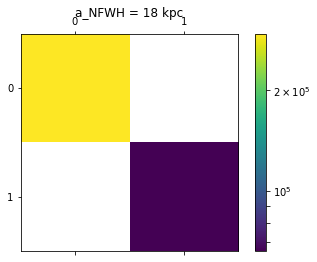

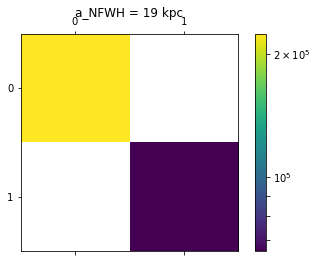

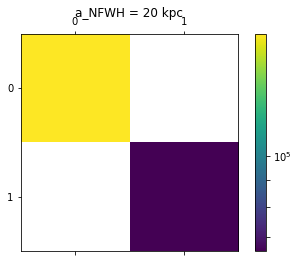

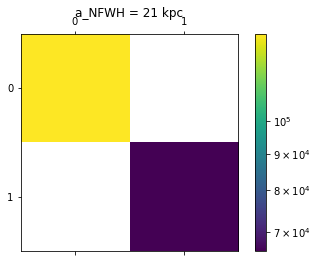

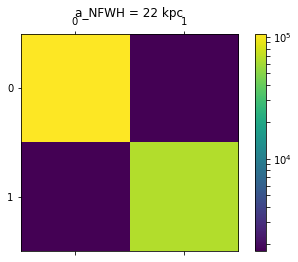

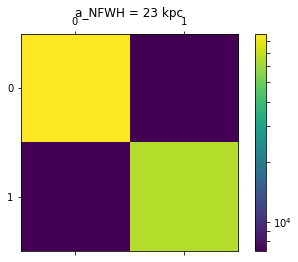

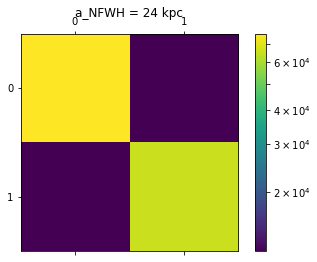

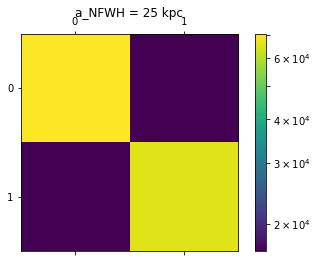

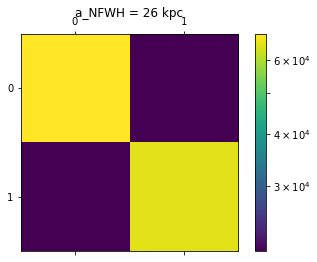

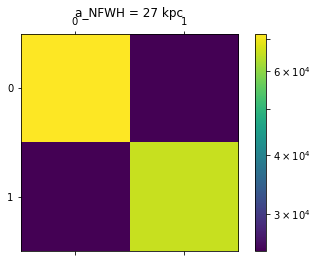

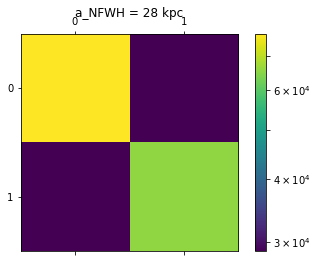

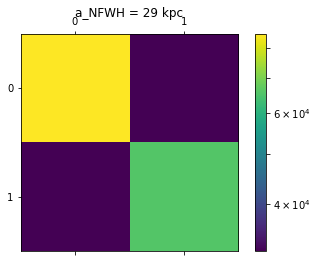

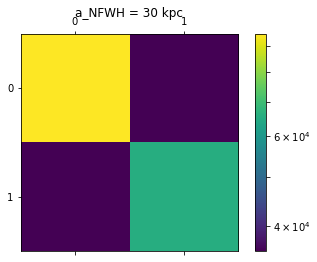

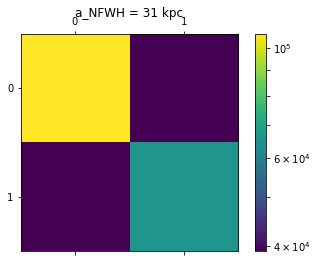

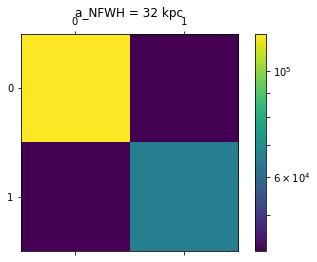

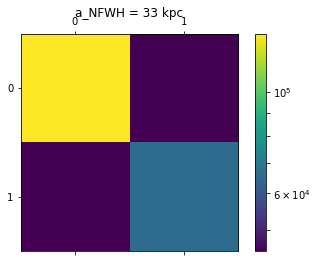

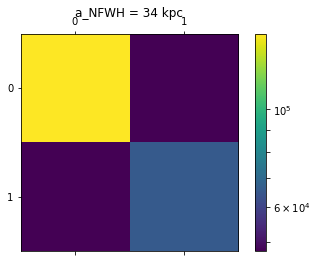

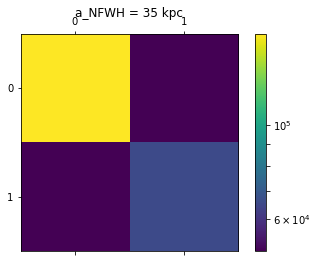

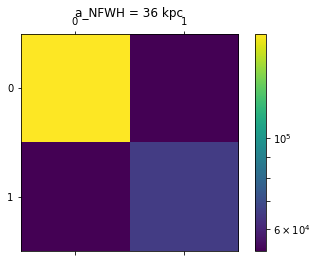

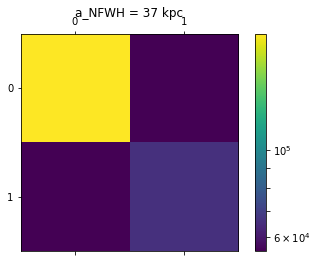

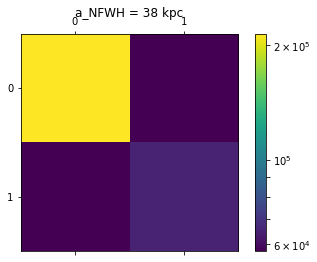

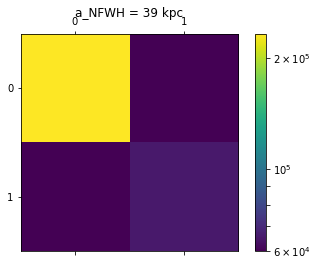

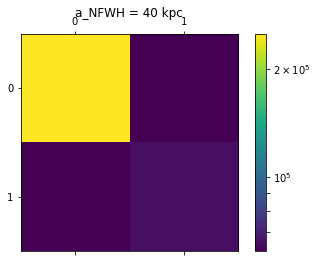

In [14]:
# try to show covariance matrix
for i in range(len(covs_jR_jz)):
    # plot correlation matrix
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(covs_jR_jz[i], norm = LogNorm())
    fig.colorbar(cax)
    ax.set_title('a_NFWH = {} kpc'.format(a_NFWH_arr[i]))
    plt.show()

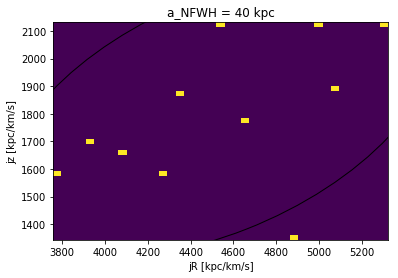

In [15]:


nstd = 2
ax = plt.subplot(111)

#cov = np.cov(x, y)
vals, vecs = eigsorted(covs_jR_jz[-1])
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
w, h = 2 * nstd * np.sqrt(vals)
ell = Ellipse(xy=(mean_jR_kpckms[-1], mean_jz_kpckms[-1]),
              width=w, height=h,
              angle=theta, color='black')
ell.set_facecolor('none')
ax.add_artist(ell)
plt.hist2d(jR_kpckms, jz_kpckms, bins = 41)
plt.xlabel('jR [kpc/km/s]')
plt.ylabel('jz [kpc/km/s]')
plt.title('a_NFWH = {} kpc'.format(a_NFWH_arr[-1]))
plt.show()

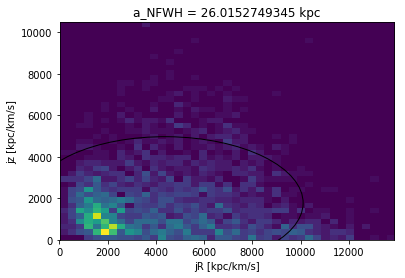

In [16]:
nstd = 2
ax = plt.subplot(111)

#cov = np.cov(x, y)
vals, vecs = eigsorted(init_cov_jR_jz)
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
w, h = 2 * nstd * np.sqrt(vals)
ell = Ellipse(xy=(init_mean_jR_kpckms, init_mean_jz_kpckms),
              width=w, height=h,
              angle=theta, color='black')
ell.set_facecolor('none')
ax.add_artist(ell)
plt.hist2d(init_jR_kpckms, init_jz_kpckms, bins = 41)
plt.xlabel('jR [kpc/km/s]')
plt.ylabel('jz [kpc/km/s]')
plt.title('a_NFWH = {} kpc'.format(init_a_NFWH_kpc))
plt.show()

In [17]:
# calculate concentration
M200 = sf.data['fmc2'][0] #M200
R200 = sf.data['frc2'][0] #R200
a = init_a_NFWH_kpc
c = a/R200

In [18]:
c 

108.01188770424625